In [5]:
import warnings

warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import h5py
from matplotlib import pyplot as plt
from matplotlib.path import Path
import matplotlib.ticker as ticker
from matplotlib import font_manager
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.kernel_ridge import KernelRidge
import scipy
from scipy.constants import physical_constants

In [2]:
def h5group_to_dict(grp):
    dct = {}
    for key, val in grp.items():
        if isinstance(val, h5py.Dataset):
            dct[key] = val[()]
        else:
            dct[key] = h5group_to_dict(val)
    return dct

In [101]:
BOHR = physical_constants["Bohr radius"][0] / 1e-10

In [8]:
rad_x = np.linspace(0, 10, 50000)

In [3]:
%%time
with h5py.File(f"rdf.h5", "r") as f:
    dict_ref = h5group_to_dict(f["CCSD"]["aug-cc-pwcv5z"])

CPU times: user 7.68 ms, sys: 4.94 ms, total: 12.6 ms
Wall time: 32.8 ms


In [55]:
%%time
dict_rdf = {}
with h5py.File(f"rdf.h5", "r") as f:
    for xc in ["MP2", "HF"]:
        dict_rdf[xc] = h5group_to_dict(f[xc]["aug-cc-pwcv5z"])
with h5py.File(f"rdf-dh.h5", "r") as f:
    for xc in ["XYG3", "XYGJ-OS", "xDH-PBE0", "revXYGJ-OS", "B2PLYP", "XYG6"]:
        dict_rdf[xc] = h5group_to_dict(f[xc.replace("-", "_")]["aug-cc-pwcv5z"])
with h5py.File(f"rdf-low.h5", "r") as f:
    for xc in ["SVWN", "BLYP", "PBE", "B3LYPV1R", "PBE0"]:
        dict_rdf[xc] = h5group_to_dict(f[xc.replace("-", "_")]["aug-cc-pwcv5z"])

CPU times: user 94.9 ms, sys: 52.5 ms, total: 147 ms
Wall time: 495 ms


Validation

(0.0, 8.0)

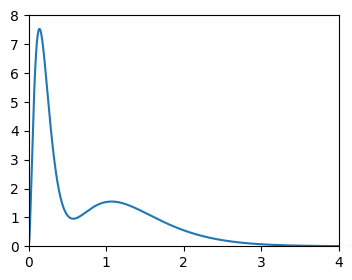

In [108]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(rad_x, dict_ref["Be+0"]["RHO"] / BOHR)
ax.set_xlim(0, 4)
ax.set_ylim(0, 8)

(0.0, 60.0)

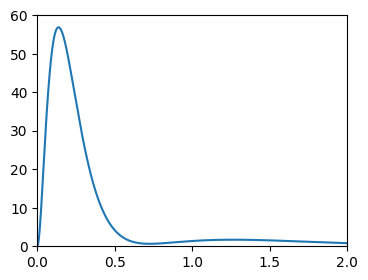

In [109]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(rad_x, dict_ref["Be+0"]["GRD"] / BOHR)
ax.set_xlim(0, 2)
ax.set_ylim(0, 60)

(-400.0, 200.0)

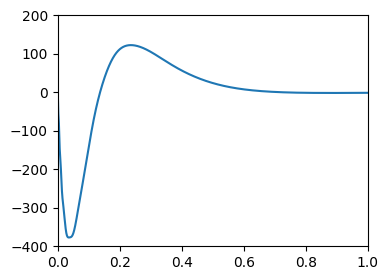

In [111]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(rad_x, dict_ref["Be+0"]["LR"] / BOHR)
ax.set_xlim(0, 1)
ax.set_ylim(-400, 200)

(-50.0, 50.0)

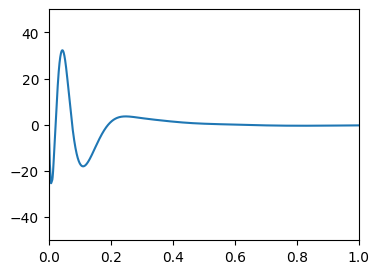

In [112]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(rad_x, (dict_rdf["B3LYPV1R"]["Ne+0"]["LR"] - dict_ref["Ne+0"]["LR"]) / BOHR)
ax.set_xlim(0, 1)
ax.set_ylim(-50, 50)

Special character: Å

In [86]:
def common_fig_configure():
    fig, axs = plt.subplots(3, 2, figsize=(9, 10), gridspec_kw={"hspace": 0.07, "wspace": 0.35})
    # set axis frame
    for idx in range(3):
        for jdx in range(2):
            ax = axs[idx, jdx]
            ax.spines["bottom"].set_position(("data", 0))
            ax.spines["top"].set_linewidth(0)
            ax.spines["right"].set_linewidth(0)
    # common x ticks
    for idx, jdx, xmax, n in zip(
            (0, 1, 2, 0, 1, 2),
            (0, 0, 0, 1, 1, 1),
            (5, 2, 1, 2.5, 1, 0.5),
            (5, 4, 5, 5, 4, 5)):
        xticks_major = np.linspace(0, xmax, n + 1)
        xticks_minor = np.linspace(0, xmax, n * 5 + 1)
        ax = axs[idx, jdx]
        ax.set_xlim(0, xmax)
        ax.set_xticks(xticks_major)
        ax.set_xticks(xticks_minor, minor=True)
        ax.set_xticklabels([""] + [f"{v:.1f}" for v in xticks_major[1:]])
    # common y labels
    for idx, jdx, ylabel in zip(
            (0, 1, 2, 0, 1, 2),
            (0, 0, 0, 1, 1, 1),
            (
                "Errors for Be RHO / e$\, \cdot \,$Å$^{-1}$",
                "Errors for Be GRD / e$\, \cdot \,$Å$^{-1} \, a_0^{-1}$",
                "Errors for Be LR / e$\, \cdot \,$Å$^{-1} \, a_0^{-2}$",
                "Errors for Ne RHO / e$\, \cdot \,$Å$^{-1}$",
                "Errors for Ne GRD / e$\, \cdot \,$Å$^{-1} \, a_0^{-1}$",
                "Errors for Ne LR / e$\, \cdot \,$Å$^{-1} \, a_0^{-2}$",
            )):
        ax = axs[idx, jdx]
        ax.set_ylabel(ylabel)
        ax.text(0.5, 0.1, "$r$ / Å", transform=ax.transAxes, verticalalignment='top', horizontalalignment="center")
    # common xlabel
    fig.tight_layout()
    return fig, axs

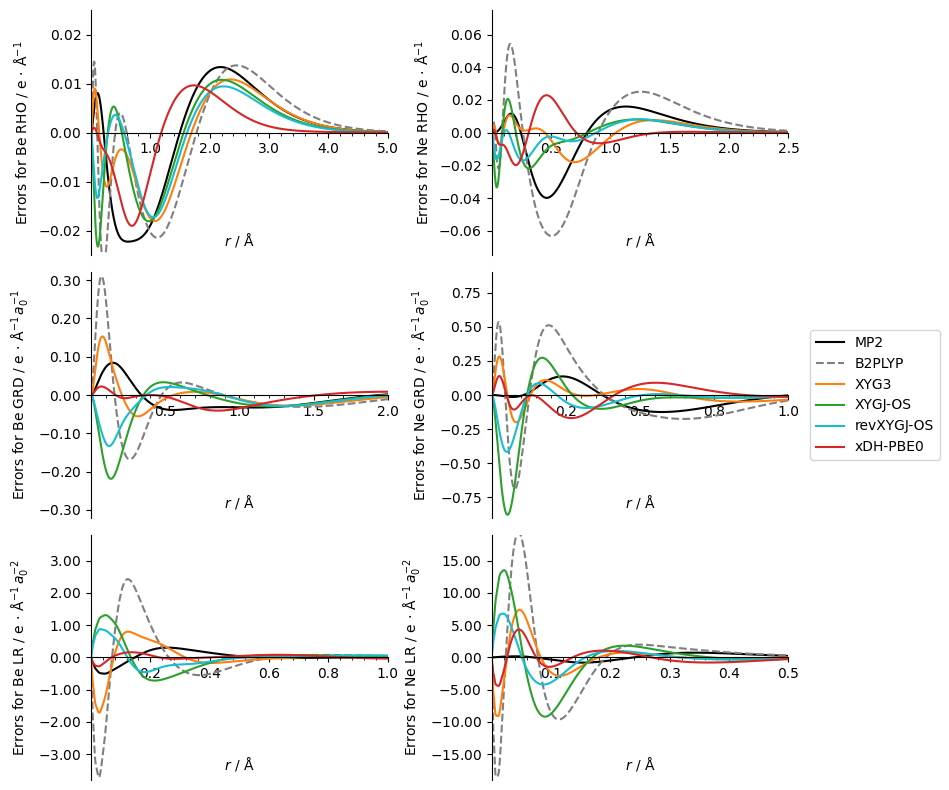

In [160]:
# Fig. S1

fig, axs = common_fig_configure()
for idx, jdx, atom, task, ylim in zip(
        (0, 1, 2, 0, 1, 2),
        (0, 0, 0, 1, 1, 1),
        ("Be+0", "Be+0", "Be+0", "Ne+0", "Ne+0", "Ne+0"),
        ("RHO", "GRD", "LR", "RHO", "GRD", "LR"),
        (0.025, 0.32, 3.8, 0.075, 0.9, 19)):
    ax = axs[idx, jdx]
    if ylim is not None:
        ax.set_ylim(-ylim, ylim)
    ax.set_yticklabels([f"${v:.2f}$" for v in ax.get_yaxis().get_ticklocs()])
    for xc, cl, ls in [
            ("MP2", "black", "-"),
            ("B2PLYP", "C7", "--"),
            ("XYG3", "C1", "-"),
            ("XYGJ-OS", "C2", "-"),
            ("revXYGJ-OS", "C9", "-"),
            ("xDH-PBE0", "C3", "-"),
        ]:
        ax.plot(rad_x, (dict_rdf[xc][atom][task] - dict_ref[atom][task]) / BOHR, color=cl, linestyle=ls, label=xc)
legend = axs[1, 1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

fig.tight_layout()
fig.savefig("../supp-fig-s1.pdf", transparent=True, bbox_extra_artists=[legend], bbox_inches="tight")

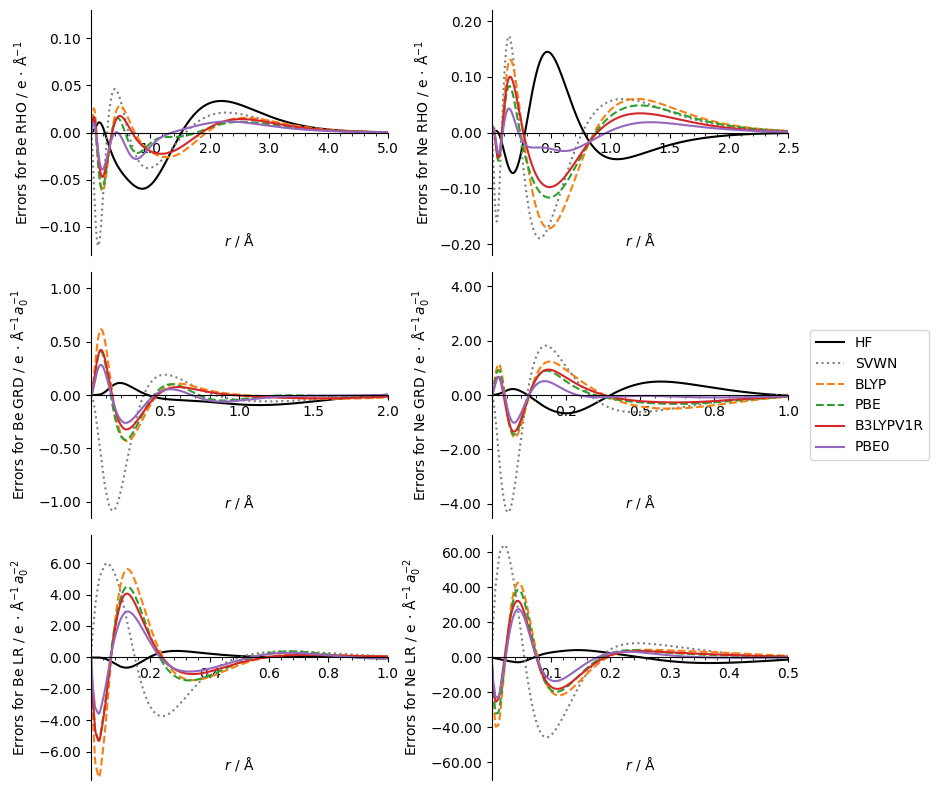

In [161]:
# Fig. S2

fig, axs = common_fig_configure()
for idx, jdx, atom, task, ylim in zip(
        (0, 1, 2, 0, 1, 2),
        (0, 0, 0, 1, 1, 1),
        ("Be+0", "Be+0", "Be+0", "Ne+0", "Ne+0", "Ne+0"),
        ("RHO", "GRD", "LR", "RHO", "GRD", "LR"),
        (0.13, 1.15, 7.8, 0.22, 4.5, 70)):
    ax = axs[idx, jdx]
    if ylim is not None:
        ax.set_ylim(-ylim, ylim)
        ax.set_yticklabels([f"${v:.2f}$" for v in ax.get_yaxis().get_ticklocs()])
    for xc, cl, ls in [
            ("HF", "black", "-"),
            ("SVWN", "C7", ":"),
            ("BLYP", "C1", "--"),
            ("PBE", "C2", "--"),
            ("B3LYPV1R", "C3", "-"),
            ("PBE0", "C4", "-"),
        ]:
        ax.plot(rad_x, (dict_rdf[xc][atom][task] - dict_ref[atom][task]) / BOHR, color=cl, linestyle=ls, label=xc)
legend = axs[1, 1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

fig.tight_layout()
fig.savefig("../supp-fig-s2.pdf", transparent=True, bbox_extra_artists=[legend], bbox_inches="tight")

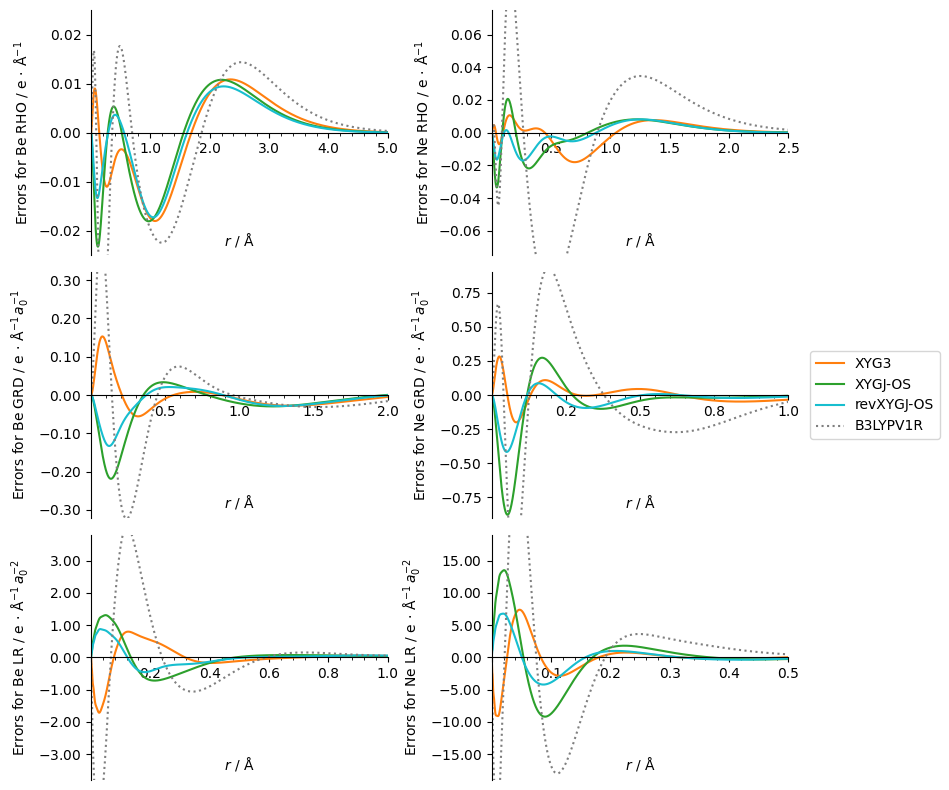

In [162]:
# Fig. S3

fig, axs = common_fig_configure()
for idx, jdx, atom, task, ylim in zip(
        (0, 1, 2, 0, 1, 2),
        (0, 0, 0, 1, 1, 1),
        ("Be+0", "Be+0", "Be+0", "Ne+0", "Ne+0", "Ne+0"),
        ("RHO", "GRD", "LR", "RHO", "GRD", "LR"),
        (0.025, 0.32, 3.8, 0.075, 0.9, 19)):
    ax = axs[idx, jdx]
    if ylim is not None:
        ax.set_ylim(-ylim, ylim)
    ax.set_yticklabels([f"${v:.2f}$" for v in ax.get_yaxis().get_ticklocs()])
    for xc, cl, ls in [
            ("XYG3", "C1", "-"),
            ("XYGJ-OS", "C2", "-"),
            ("revXYGJ-OS", "C9", "-"),
            ("B3LYPV1R", "C7", ":"),
        ]:
        ax.plot(rad_x, (dict_rdf[xc][atom][task] - dict_ref[atom][task]) / BOHR, color=cl, linestyle=ls, label=xc)
legend = axs[1, 1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

fig.tight_layout()
fig.savefig("../supp-fig-s3.pdf", transparent=True, bbox_extra_artists=[legend], bbox_inches="tight")

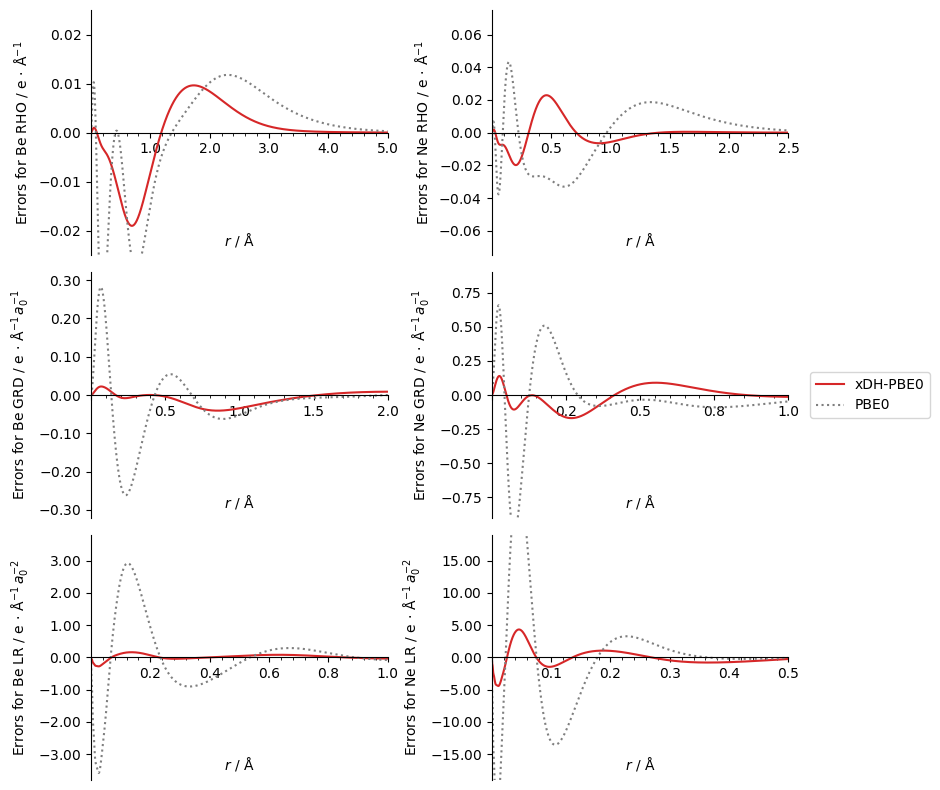

In [163]:
# Fig. S4

fig, axs = common_fig_configure()
for idx, jdx, atom, task, ylim in zip(
        (0, 1, 2, 0, 1, 2),
        (0, 0, 0, 1, 1, 1),
        ("Be+0", "Be+0", "Be+0", "Ne+0", "Ne+0", "Ne+0"),
        ("RHO", "GRD", "LR", "RHO", "GRD", "LR"),
        (0.025, 0.32, 3.8, 0.075, 0.9, 19)):
    ax = axs[idx, jdx]
    if ylim is not None:
        ax.set_ylim(-ylim, ylim)
    ax.set_yticklabels([f"${v:.2f}$" for v in ax.get_yaxis().get_ticklocs()])
    for xc, cl, ls in [
            ("xDH-PBE0", "C3", "-"),
            ("PBE0", "C7", ":"),
        ]:
        ax.plot(rad_x, (dict_rdf[xc][atom][task] - dict_ref[atom][task]) / BOHR, color=cl, linestyle=ls, label=xc)
legend = axs[1, 1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

fig.tight_layout()
fig.savefig("../supp-fig-s4.pdf", transparent=True, bbox_extra_artists=[legend], bbox_inches="tight")